<hr style="height:2px;border:none"/>
<h1 align='center'> <img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />

INF-395 / 477 / 577 Tarea 2 Redes Neuronales Artificiales - 2020-2 </h1>

<H3 align='center'> Integrantes: Kevin Reyes - Diego Quezada </H3>
<hr style="height:2px;border:none"/>


**Temas**  
* Manipulaciones en tensorflow, keras, pandas y numpy
* Recurrent Neural Networks
* LSTM, GRU
* Autoencoders
* GAN

**Formalidades**  
* Equipos de trabajo de 2 personas (*Ambos estudiantes deben estar preparados para presentar la tarea el día de la entrega*)
* El entregable debe ser un _Jupyter Notebook_ incluyendo los códigos utilizados, los resultados, los gráficos realizados y comentarios. Debe seguir una estructura similar a un informe (se debe introducir los problemas a trabajar, presentar los resultados y discutirlos). Si lo prefiere puede entregar un _Jupyter Notebook_ por pregunta o uno para toda la tarea, con tal de que todos los entregables estén bien identificados y se encuentren en el mismo repositorio de _Github_.
* Se debe preparar una presentación del trabajo realizado y sus hallazgos. El presentador será elegido aleatoriamente y deberá apoyarse en el _Jupyter Notebook_ que entregarán. 
* Formato de entrega: envı́o de link del repositorio en _Github_ ( en caso de ser repositorio privado, invitar como colaborador al usuario de github "Aerlio") al correo electrónico del ayudante (*<tomas.ochoa.14@sansano.usm.cl>*), en copia al profesor (*<cvalle@inf.utfsm.cl>*). Especificar el siguiente asunto: [INF395/477/577-2020 Tarea 2]
* Fecha de entrega y presentaciones: 8 de Enero. Hora límite de entrega: 23:00. Cualquier _commit_ luego de la hora límite no será evaluado. Se realizará descuento por atrasos en envío del mail. 

<hr style="height:2px;border:none"/>

La tarea se divide en tres partes:

[1.](#primero) RNNs para series de tiempo  <br>
[2.](#segundo) RNNs para texto <br>
[3.](#tercero) Autoencoders para imágenes <br>
[3.](#cuarto) GANs para imágenes <br>

La tarea tiene ejemplos de códigos con los cuales pueden guiarse en gran parte, sin embargo solo son guías y pueden ser creativos al momento de resolver la tarea. Soluciones creativas o elegantes serán valoradas. También en algunas ocaciones se hacen elecciones arbitrarias, ustedes pueden realizar otras elecciones con tal de que haya una pequeña justificación de por qué su elección es mejor o equivalente.
Recuerden intercalar su código con comentarios y con celdas _Markdown_ con los comentarios de la pregunta y con cualquier analisis, fórmula o explicación que les parezca relevante para justificar sus procedimientos. 
Noten que en general cuando se les pide elegir algo o proponer algo no se evaluará mucho la elección en si, en cambio la argumentación detrás de la elección será lo más ponderado.

**Es ÁLTAMENTE recomendado realizar esta tarea en _Colab_ de Google (https://colab.research.google.com/notebooks/intro.ipynb#recent=true), con el fin de no depender del rendimiento de su computador personal al momento de entrenar redes neuronales y poder compartir de forma fácil sus avances con su compañer@ de trabajo.** Si bien conlleva sus pros y contras utilizar _Colab_ , existirá una curva de aprendizaje personal que lo ayudará a sacar el mayor provecho a esta herramienta, por ejemplo aprendiendo a guardar los avances realizados, evitando tener que ejecutar todo el código cada vez que se abra _Colab_ . *Tip: Una vez abierto un notebook en _Colab_ ir a **entorno de ejecución**->**Cambiar tipo de entorno de ejecución**, y seleccionár TPU como acelerador por hardware para redes recurrentes y GPU para redes convolucionales.*.

In [54]:
import random

In [55]:
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(1)
random.seed(1)

In [56]:
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
tf.compat.v1.set_random_seed(1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

# 2. RNN sobre texto

Hoy en dı́a, una aplicación relevante de las redes neuronales recurrentes es el modelamiento de texto y lenguaje natural. En esta sección abordaremos el problema de procesar sentencias de texto, proporcionadas por GMB (*Groningen Meaning Bank*), para reconocimiento de entidades y tagger. En específico, trabajaremos con el dataset proprocionado a través de __[Kaggle](https://www.kaggle.com/abhinavwalia95/entity-annotated-corpus)__, que está compuesto por más de un millón de palabras, a fin de realizar predicciones sobre distintas tareas del tipo *many to many* y *many to one*.

<img src="https://i.stack.imgur.com/b4sus.jpg" width="70%" />


## 2.a Carga de datos y preprocesamientos


##### I) Investigue en la documentación del dataset cual es la tarea original para el cual fue propuesto, en particular cuál es la variable que buscamos predecir, a qué se refiere esta misma y por qué es necesario utilizar técnicas avanzadas para resolver esta tarea (¿no bastaría con un diccionario?).

**Respuesta:**
La tarea original del dataset fue identificar entidades nombradas (o etiquetadas) a partir de textos, en particular entidades como nombre y ubicación.
La variable que buscamos predecir son la o las entidades que participan en una oración. esta se refiere a identificar información crucial o bien de interés
de un texto. No bastaría con un diccionario pues este nos daría información acotada que no consideraría una arquitectura recurrente. Esta última nos permite identificar entidades de interés en
oraciones complejas en donde la entidad no está explícita, por lo que no es posible obtener obtener una predicción correcta a partir de un simple diccionario.


Cargue el conjunto de datos. Este conjunto de datos es bastante grande, por lo que como ven en el código propuesto, nos contentaremos con no considerar las lineas corruptas del registro.

En esta primera instancia trabajaremos con la tarea de realizar un NER *tag* (**Named Entity Recognition**) sobre cada una de las palabras en las sentencias que se nos presenta en los datos. Esta tarea es del tipo *many to many*, es decir, la entrada es una secuencia y la salida es una secuencia, sin *shift*, por lo que necesitaremos una estructura de red adecuada a ésto. En primer lugar extraiga las columnas que utilizaremos del dataset **¿Por qué es conveniente utilizar *lemma* en vez de la palabra misma *word*?**  
**Respuesta:** 
Porque cada palabra puede tener múltiples variaciones, por ejemplo, *trabajar* en inglés en los distintos
tiempos y personas podría ser: work, worked, working y works, cada una de estas palabras tiene
el mismo significado pero en distinto tiempo o persona, por lo que, es útil utilizar
lemmatization para llevar todas las palabras a su raiz y así sacar el máximo de provecho
al aprendizaje, ya que, en vez de tener que aprender work, worked, working y works, estaremos
aprendiendo work y su uso se puede interpretar dado el contexto, esto es útil para nuestro
problema en específico, ya que, para reconocer entidades en una secuencia no es relevante
el tiempo o la persona que se use.


In [57]:
import matplotlib.pyplot as plt
import tensorflow as tf

In [58]:
username="diegoquezada21"
key="afb1882970f4ac5726f12dda7bf92f7c"
!pip install -q kaggle
api_token = {"username":username,"key":key}
import json
import zipfile
import os
os.environ['KAGGLE_USERNAME'] = str(username)
os.environ['KAGGLE_KEY'] = str(key)
!kaggle datasets download -d abhinavwalia95/entity-annotated-corpus
if not os.path.exists("/content/NER"):
    os.makedirs("/content/NER")
os.chdir('/content/NER')
for file in os.listdir():
    if file[-4:]==".zip":
      zip_ref = zipfile.ZipFile(file, 'r')
      zip_ref.extractall()
      zip_ref.close()
!ls

entity-annotated-corpus.zip: Skipping, found more recently modified local copy (use --force to force download)
entity-annotated-corpus.zip  ner.csv  ner_dataset.csv


In [59]:
import numpy as np
import pandas as pd

df_ner = pd.read_csv("ner.csv", encoding ="cp1252", error_bad_lines=False)
df_ner.dropna(inplace=True)
dataset = df_ner.loc[:,['lemma','tag','word','sentence_idx']]
dataset[0:200]

b'Skipping line 281837: expected 25 fields, saw 34\n'


,lemma,tag,word,sentence_idx
0,thousand,O,Thousands,1.0
1,of,O,of,1.0
2,demonstr,O,demonstrators,1.0
3,have,O,have,1.0
4,march,O,marched,1.0
...,...,...,...,...
195,.,O,.,9.0
196,iranian,B-gpe,Iranian,10.0
197,offici,O,officials,10.0
198,say,O,say,10.0


##### II) Para poder utilizar este conjunto de datos, debemos transformar nuestra tabla de palabras y sentencias, a una tabla donde cada entrada sea una sentencia, ademas codificando los distintos lemmas y tags como valores numéricos. Esto pueden realizarlo con alguna de las utilidades de keras o sklearn, sin embargo en el código siguiente se propone un metodo solo usando python y pandas. Pueden utilizar el método que deseen. Note eso si que independiente la aproximación que utilice debe comenzar desde 1 para la codificación, pues el valor 0 lo reservaremos para representar la ausencia de palabras más adelante.

**Explique qué realiza cada linea del código.**

In [60]:
import numpy as np

# Crea un diccionario donde a cada lemma se le asigna un código numérico partiendo desde el 1
lemma_to_code = {lemma:code+1 for code, lemma in enumerate(dataset.lemma.unique())}
# Crea un diccionario donde a cada tag se le asigna un código numérico partiendo desde el 1
tag_to_code = {tag:code+1 for code, tag in enumerate(dataset.tag.unique())}
# Calcula la cantidad de lemmas
n_lemmas = len(lemma_to_code) 
lemmas = dataset.lemma.unique()
tags = dataset.tag.unique()
# cambia el valor de cada registro de lemma en el dataset por el código numérico generado
dataset['lemma'] = dataset.lemma.apply(lambda x: lemma_to_code[x])
# cambia el valor de cada registro de tag en el dataset por el código numérico generado
dataset['tag'] = dataset.tag.apply(lambda x: tag_to_code[x])

# Primero las palabras se agrupan por la sentencia a la que pertenecen
# Cada grupo se transforma en una lista y luego se convierte en un array de numpy
dff = dataset.groupby("sentence_idx")[['lemma','tag']].agg(list).applymap(np.asarray)

## 2.b) Distribuciones.

Ahora que ya tenemos las sentencias codificadas y agrupadas, explore el tamaño de estas, en número de lemmas: ¿Son todas las sentencias de igual tamaño? ¿Le hace sentido esto? ¿Las redes que conoce pueden manajar ejemplos de distintos tamaños, y si pueden qué problemas podría traer? ¿Están las clases repartidas de manera equitativa?

**Respuesta:** No son sentencias del mismo tamaño, esto tiene sentido pues en la práctica no se trabajará con sentencias de un mismo largo.
Al momento de entrenar RNN's es necesaro definir la forma del input, sin embargo estas no dependen del largo de la secuencia a la hora de inferir.
Los problemas que esto podría tener ocurren en el entrenamiento, cuando no exista un calce perfecto entre el tamaño de cada input con el largo total
de la secuencia de forma que en algún momento se deba alimentar la red con un input de dimensiones distintas, en estos casos se puede **truncar** o utilizar **padding**.

Las clases no están repartidas de manera equitativa, sentencias con un largo de aproximadamente 20 palabras están sobrerepresentadas.


Estudie la distribución del largo de los textos a procesar. Estudie también la frecuencia con la que aparecen las palabras en todo el dataset. **¿Se observa una ley Zipf?** (https://es.wikipedia.org/wiki/Ley_de_Zipf). Realice un gráfico de la cantidad de datos por clase. Comente.

**Respuesta:** Efectivamente podemos observar la ley Zipf. Esto se evidencia en nuestro último gráfico de esta sección, donde vemos que
al graficar los lemas según su frecuencia de mayor a menor obtenemos una función con el mismo comportamiento que una de la forma $\displaystyle f(x) = \frac{1}{x^a}$

In [61]:
print(n_lemmas)
n_tags = len(tag_to_code)
print(n_tags)
#print(dff['lemma'].applymap(len))
largos_sentencias = list(map(len,dff['lemma'].tolist() ))

20243
17


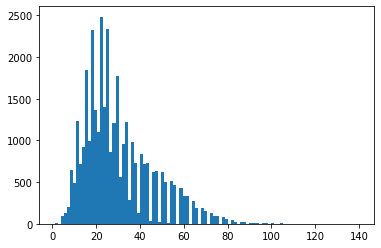

In [62]:
plt.hist(largos_sentencias,bins=100)
plt.show()

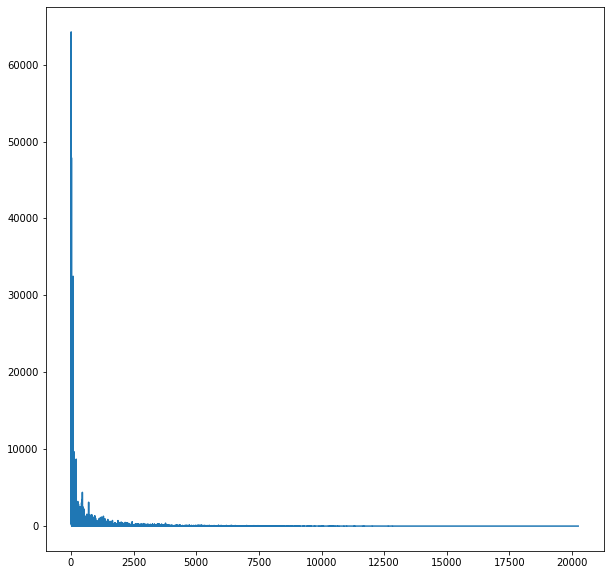

In [63]:
%matplotlib inline
lemma_frequence_2 = pd.Series(np.concatenate([x for x in dff["lemma"]])).value_counts().sort_index()
#plt.hist(lemma_frequence_2.values,bins = lemma_frequence_2.index.map(str))
#plt.hist(lemma_frequence_2.values, bins = lemma_frequence_2.index.to_numpy())
lemma_frequence_2.plot(figsize=(10,10))

## 2.c) Padding y one hot vectors


##### I) En esta parte de la tarea, deben lograr que todas las secuencias de lemmas (y los tags correspondientes) queden del mismo largo, es decir realizar padding. El padding debe realizarse con el valor 0, pueden escoger si realizarlo al comienzo de la secuencia o al final, expliquen su elección. Pueden utilizar la función keras.preprocessing.sequence.pad_sequences o escribir sus propios códigos. Elija un valor de maxlen que le parezca adecuado.
**Respuesta:**


**Post padding:** En el inglés, español y otros lenguajes, gramaticalmente las entidades
suelen ser nombradas al principio de las sentencias, por ejemplo, "La organización logró sus
objetivos este año". Por lo anterior, nos deberíamos asegurar que las neuronas que reciben
la parte inicial de las sentencias trabajen con datos válidos.  



¿Opinan que es deseable utilizar el valor 0 como codificación de palabras que "no existen", o creen que es irrelevante por ejemplo que su valor sea 1?

**Respuesta:**  
Es deseable dependiendo del diccionario, en nuestro caso la codificación numérica
de los lemmas parte desde el 1, por lo que, al hacer padding debemos evitar
utilizar un número que sea parte de los lemmas, ya que, en ese caso estaríamos añadiendo
palabras con significado a la sentencia, al utilizar el 0 que no es parte de diccionario
estamos añadiendo un elemento neutro.

In [64]:
mean_sentencias = sum(largos_sentencias)/len(largos_sentencias)
print(mean_sentencias)

29.871620661227507


In [65]:
from keras.preprocessing.sequence import pad_sequences
max_len = 30  # Promedio de largos de secuencias
X = pad_sequences(dff['lemma'], maxlen=max_len,padding='post') # 0 al inicio por default
Y = dff['tag'].values
Y = pad_sequences(Y, maxlen=max_len,padding='post') # 0 al inicio por default

##### II) Para poder entregar una clasificación sobre los distintos *tags* es necesario transformarlos a *one hot vectors*, debido a que están codificados en números enteros, esto resultará en un arreglo tridimensional con la cantidad de ejemplos, la cantidad máxima de palabras y la cantidad de posibles *tags*. Luego de esto cree los conjuntos de entrenamiento y de prueba con el código a continuación **¿Cuáles son las dimensiones de entrada y salida de cada conjunto?** Comente

**Dimensiones de entrada:** Para el conjunto de entrenamiento tenemos 26382 ejemplos y para validar tenemos 8795 , donde cada uno es un arreglo de 30 lemmas, es decir,
una sentencia codificada numéricamente.  
**Dimensiones de salida:**  Para el conjunto de entrenamiento tenemos 26382 ejemplos y para validar tenemos 8795 , donde cada elemento de salida es un arreglo con la
sentencia completa, que a su vez cada elemento de la sentencia tiene asociado un arreglo de dimensión 18 (debería ser 17, pero por un error de keras se sumo 1 al largo del one-hot-vector),
el cual tiene en el elemento $i$ la probabilidad de que ese lemma sea de la clase/tag $i$

In [66]:
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
y = np.asarray([to_categorical(i, num_classes=n_tags + 1) for i in Y])

In [67]:
x_tr, x_val, y_tr, y_val = train_test_split(X, y, test_size=0.25, random_state=1)

In [68]:
x_tr.shape,y_tr.shape,x_val.shape,y_val.shape

((26382, 30), (26382, 30, 18), (8795, 30), (8795, 30, 18))

## 2.d) RNN many to many



##### I) Defina una red neuronal recurrente *many to many* con compuertas LSTM para aprender a *tagear* la entidad en el texto, entrene y evalúe su desempeño sobre ambos conjuntos. Esta red debe procesar la secuencia de *lemmas* rellenados (o sin rellenar) y entregar el *tag* a cada uno de los *lemmas*, por lo que la salida de la red no es un vector como anteriormente se ha trabajado, sino que tiene una dimensión extra la cual es debido a que en cada instante de tiempo se necesita entregar un *output*. Como los *lemmas* corresponden a datos esencialmente categóricos, o al menos discretos, es necesario generar una representación vectorial de ellas. La primera capa de la red a construir debe por lo tanto incluir una transformación entrenable desde el espacio de representación original (discreto) a ${\rm I\!R}^{d}$ , con $d$ la dimensionalidad del *embedding*. **Comente sobre los cambios que sufre un dato al ingresar a la red y la cantidad de parámetros de la red**.

**Respuesta:**

1. Input -> [30].
2. Embedding -> [30, 32]
3. LSTM -> [30, 128]
4. Dense -> [30,18]


Al ingresar una secuencia al embedding, cada lemma de la secuencia se lleva a una representación vectorial de 32 dimensiones, por lo que, la salida es una secuencia de largo 30
donde cada elemento es un vector de 32. Esta secuencia alimenta a la LSTM, la cual retorna una secuencia de 30 elementos (return_sequences=True), donde cada 
elemento tiene el output de las 128 celdas de la LSTM. Finalmente esto alimenta a la capa densa, la que devuelve la secuencia de 30 elementos, donde cada elemento 
es un vector de largo 18 (17+1), donde el elemento $i$ del vector representa la probabilidad del lemma de ser del tag $i$. 



In [69]:
from keras.models import Sequential
from keras.layers import LSTM, Embedding, Dense
x_tr = np.asarray(x_tr).astype('float32')
x_val = np.asarray(x_val).astype('float32')
max_len = 30

#¿problemas con el embedding al ejecutar? chequear que el n_lemas, n_tags, y max_len correspondan a los datos modificados con padding
m = Sequential()
embedding_dim = 32
m.add(Embedding(input_dim=n_lemmas+1, output_dim=embedding_dim, input_length=max_len))
m.add(LSTM(units=128,return_sequences=True))
m.add(Dense(n_tags+1, activation='softmax'))
m.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['acc'])
#history = m.fit(x_tr,y_tr, validation_data=(x_val,y_val), epochs=3, batch_size=128)

In [70]:
m.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 30, 32)            647808    
_________________________________________________________________
lstm_3 (LSTM)                (None, 30, 128)           82432     
_________________________________________________________________
dense_3 (Dense)              (None, 30, 18)            2322      
Total params: 732,562
Trainable params: 732,562
Non-trainable params: 0
_________________________________________________________________


In [71]:
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [72]:
#pip install sklearn-crfsuite

Para evaluar su modelo utilice una métrica adecauda para el desbalance presente entre las clases.

In [95]:
from sklearn_crfsuite.metrics import flat_classification_report

  
y_pred = m.predict(x_val)
y_pred = (y_pred > 0.5)


print(flat_classification_report(y_val,y_pred))

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.87      0.95      0.91    152888
           1       0.98      0.91      0.94    206567
           2       0.84      0.49      0.62      8734
           3       0.99      0.09      0.16      3771
           4       0.82      0.19      0.30      3633
           5       0.71      0.12      0.21      1700
           6       0.00      0.00      0.00      4577
           7       0.00      0.00      0.00      3712
           8       0.95      0.49      0.65      4643
           9       0.00      0.00      0.00        83
          10       0.00      0.00      0.00        55
          11       0.63      0.56      0.60      3717
          12       0.00      0.00      0.00        43
          13       1.00      0.03      0.06      1409
          14       0.00      0.00      0.00        60
          15       0.00      0.00      0.00        84
          16       0.00      0.00      0.00        76
          17       0.00    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##### II) Varı́e la dimensionalidad del embedding inicial y determine si **aumenta o disminuye el error de clasificación**. Comente.

**Respuesta:** Al experimentar con dimensionalidades mayores a 30 para el embedding no obtenemos una mejora considerable basandonos en la
precisión por weighted average. Con una dimensionalidad de 25 obtenemos resultados practicamente iguales a los obtenidos con 30, sin embargo
al comenzar a disminuir aún más la dimensionalidad del embeddng obtenemos peores resultados. Esto es claro pues 
estamos reduciendo en exceso la dimensionalidad de la representación matemática de nuestro vocabulario (lemmas), por lo que, la capa de embedding no logra aprender
todos los patrones entre los lemmas del dataset, es decir, desde cierta dimensión hacia abajo aparece un problema de underfitting del vocabulario utilizado.

In [74]:
#¿problemas con el embedding al ejecutar? chequear que el n_lemas, n_tags, y max_len correspondan a los datos modificados con padding
m = Sequential()
embedding_dim = 25
m.add(Embedding(input_dim=n_lemmas+1, output_dim=embedding_dim, input_length=max_len))
m.add(LSTM(units=128,return_sequences=True))
m.add(Dense(n_tags+1, activation='softmax'))
m.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['acc'])
history = m.fit(x_tr,y_tr, validation_data=(x_val,y_val), epochs=3, batch_size=128)

Epoch 1/3
207/207 [==============================] - 5s 16ms/step - loss: 1.4532 - acc: 0.7412 - val_loss: 0.4648 - val_acc: 0.8822
Epoch 2/3
207/207 [==============================] - 3s 13ms/step - loss: 0.3986 - acc: 0.8913 - val_loss: 0.2957 - val_acc: 0.9137
Epoch 3/3
207/207 [==============================] - 3s 14ms/step - loss: 0.2712 - acc: 0.9232 - val_loss: 0.2270 - val_acc: 0.9433


In [75]:
y_pred = m.predict(x_val)
y_pred = (y_pred > 0.5) 
print(flat_classification_report(y_val,y_pred))#, labels=tag_to_code))

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     54637
           1       0.97      0.98      0.98    178340
           2       0.86      0.52      0.65      7537
           3       0.99      0.12      0.21      3143
           4       0.82      0.22      0.34      3033
           5       0.72      0.13      0.22      1482
           6       0.00      0.00      0.00      3821
           7       0.00      0.00      0.00      3139
           8       0.96      0.58      0.72      4017
           9       0.00      0.00      0.00        68
          10       0.00      0.00      0.00        44
          11       0.82      0.57      0.67      3121
          12       0.00      0.00      0.00        33
          13       1.00      0.03      0.06      1228
          14       0.00      0.00      0.00        50
          15       0.00      0.00      0.00        72
          16       0.00      0.00      0.00        64
          17       0.00    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 2.e) RNN Bidireccional y masking


##### I) Algunos autores señalan la importante dependencia que existe en texto, no solo con las palabras anteriores, sino que con las que siguen.**Mejore la red definida en 2.d.I) utilizando una red neuronal recurrente Bidireccional**, es decir, con recurrencia en ambas direcciones sobre la secuencia de *lemmas* de entrada. Comente **cuál debiera ser la forma correcta de usar el parámetro *merge_mode*** (concatenar, multiplicar, sumar o promediar) para este caso. Además comente las transformaciones que sufre el patrón de entrada al pasar por las capas. **¿Mejora o empeora el desempeño?** Analice.


La forma correcta (o con la que obtenemos mejor resultados) de utilizar el parametro merge_mode es sum. Esto debido a que como planteamos anteriormente la información más relevante la obtenemos con el paso del inicio al final (forward), 
de forma que si por ejemplo utilizamos mult y el pasado nos indica una probabilidad cercana a 1 mientras que el futuro (backward) una cercana a cero al hacer merge obtendremos un output cercano a cero. Al utilizar sum
simplemente tomamos la probabilidad que nos indica el pasado (forward) para casos donde el futuro nos indica una probabilidad cercana a 0. Notar además que al utilizar concat no se descarta información debido a que no hacemos un merge como tal, de hecho se aumenta la dimensionalidad del output de la LSTM y la tarea de identificar las ponderaciones de importancia recae sobre la capa densa
sin embargo para esta aplicación esto resulta en un gasto innecesario de recursos computacionales debido a 


Empeoro levemente el desempeño. En problemas como predecir la siguiente palabra en una sentencia, es realmente útil conocer el contexto futuro (lo que se espera decir
después de la palabra a predecir), en cambio, en el problema de predicción de tipo de entidad, dada la forma en que estructuramos el lenguaje normalmente las palabras
que utilizamos antes nos permiten reconocer con mayor facilidad una entidad que será nombrada. En el ejemplo 1, notamos como antes de mencionar **Hyde Park**
se utiliza la palabra **in**, el cual es un patrón recurrente la momento de hablar de un lugar físico con ciertas características (en inglés), las palabras que
aparecen después de **Hyde Park**, no son realmente utiles, ya que, son muy específicas, por lo que, no ayudarán a mejorar la capacidad de generalización del modelo.
En el ejemplo 2, observamos lo mismo para **Britain's**, la palabra **of** es un patrón típico antes de mencionar un B-Geo, la misma regla puede ser aplicada para
el resto de palabras en negritas, normalmente lo más importante para reconocer el tipo de una entidad está en el contexto pasado de la sentencia.  

Ejemplos:
   
1. They marched from the houses of parliament to a rally in **Hyde Park**. Police put the number of marchers at 10.000...  
2. the annual conference of **Britain's** ruling **Labor Party** in the **southern English** seaside resort of Brighton. The party is ...

In [76]:
from keras.layers import Bidirectional
model = Sequential()
model.add(Embedding(input_dim=n_lemmas + 1, output_dim=embedding_dim, input_length=max_len))
layer_lstm = LSTM(units=128,return_sequences=True)
model.add(Bidirectional(layer_lstm,merge_mode="concat")) # 'sum', 'mul', 'concat', 'ave'
model.add(Dense(n_tags + 1, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['acc'])
history = model.fit(x_tr,y_tr, validation_data=(x_val,y_val), epochs=3, batch_size=128)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 30, 25)            506100    
_________________________________________________________________
bidirectional (Bidirectional (None, 30, 256)           157696    
_________________________________________________________________
dense_5 (Dense)              (None, 30, 18)            4626      
Total params: 668,422
Trainable params: 668,422
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
207/207 [==============================] - 7s 21ms/step - loss: 1.2446 - acc: 0.7559 - val_loss: 0.3945 - val_acc: 0.8862
Epoch 2/3
207/207 [==============================] - 3s 16ms/step - loss: 0.3403 - acc: 0.9000 - val_loss: 0.2329 - val_acc: 0.9350
Epoch 3/3
207/207 [==============================] - 3s 16ms/step - loss: 0.1984 - acc: 0.9452 - val_loss: 0.1616 

In [77]:
y_pred_2e = model.predict(x_val)
y_pred_2e = (y_pred_2e > 0.5) 
print(flat_classification_report(y_val,y_pred_2e))#, labels=tag_to_code))

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     54637
           1       0.98      0.98      0.98    178340
           2       0.86      0.69      0.76      7537
           3       0.95      0.87      0.91      3143
           4       0.83      0.54      0.66      3033
           5       0.79      0.45      0.58      1482
           6       0.90      0.18      0.30      3821
           7       0.83      0.13      0.23      3139
           8       0.92      0.72      0.81      4017
           9       0.00      0.00      0.00        68
          10       0.00      0.00      0.00        44
          11       0.81      0.69      0.75      3121
          12       0.00      0.00      0.00        33
          13       0.81      0.37      0.50      1228
          14       0.00      0.00      0.00        50
          15       0.00      0.00      0.00        72
          16       0.00      0.00      0.00        64
          17       0.00    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##### II) Recientemente se ha implementado la capa de *Masking* en las redes recurrentes en *keras*, lo cual podría traer gran ayuda gracias al *padding* que se realiza con el símbolo especial definido. Entrene la red definida en 2.d.I) y compare al utilizar esta funcionalidad de enmascarar el valor 0  en este caso para el default de la capa embedding.
**Respuesta:** 

Al utilizar mask_zero = True obtenemos un peor desempeño, al parecer no nos sirve debido a que la aplicamos de forma errónea. Sin embargo, también podemos enmascarar el valor 0 agregando una capa Masking luego del Embedding, para este caso sí obtuvimos mejores resultados.

Usando Masking obtenemos para el weighted average los valores 0.97, 0.96 y 0.96. Para el modelo de la pregunta 2.d.I obtenemos los valores 0.91, 0.87 y 0.87. 

Es de esperarse esta mejora debido a que a diferencia del modelo anterior, ahora no estamos tomando en cuenta los ceros introducidos por el padding en el aprendizaje, es decir estamos disminuyendo una fuente de error en los datos.


In [185]:
from keras.layers import Masking
m_2e2 = Sequential()
m_2e2.add(Embedding(input_dim=n_lemmas + 1, output_dim=embedding_dim))
m_2e2.add(Masking(mask_value=0.0))
m_2e2.add(LSTM(units=128,return_sequences=True))
m_2e2.add(Dense(n_tags+1, activation='softmax'))
m_2e2.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['acc'])
history = m_2e2.fit(x_tr,y_tr, validation_data=(x_val,y_val), epochs=3, batch_size=128)

Epoch 1/3
207/207 [==============================] - 13s 41ms/step - loss: 1.1027 - acc: 0.8324 - val_loss: 0.2714 - val_acc: 0.9259
Epoch 2/3
207/207 [==============================] - 7s 35ms/step - loss: 0.2342 - acc: 0.9354 - val_loss: 0.1548 - val_acc: 0.9591
Epoch 3/3
207/207 [==============================] - 7s 35ms/step - loss: 0.1330 - acc: 0.9644 - val_loss: 0.1176 - val_acc: 0.9669


In [186]:
y_pred_2e2 = m_2e2.predict(x_val)
y_pred_2e2 = (y_pred_2e2 > 0.5) 
print(flat_classification_report(y_val,y_pred_2e2))#, labels=tag_to_code))

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    152888
           1       0.97      0.99      0.98    206567
           2       0.85      0.72      0.78      8734
           3       0.96      0.87      0.91      3771
           4       0.83      0.66      0.73      3633
           5       0.85      0.49      0.62      1700
           6       0.79      0.36      0.49      4577
           7       0.75      0.36      0.49      3712
           8       0.92      0.72      0.81      4643
           9       0.00      0.00      0.00        83
          10       0.00      0.00      0.00        55
          11       0.83      0.83      0.83      3717
          12       0.00      0.00      0.00        43
          13       0.83      0.44      0.58      1409
          14       0.00      0.00      0.00        60
          15       0.00      0.00      0.00        84
          16       0.00      0.00      0.00        76
          17       0.00    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 2.f) Mejora libre

En base a lo experimentado, **intente mejorar el desempeño de las redes encontradas**, ya sea utilizando y combinando las distintas variaciones que se hicieron en los distintos ítemes, como bien alguna mejora en el pre-proceso de los datos (largo de secuencia, el tipo de *padding* o alguna otra), agregar mayor profundidad, variar el número de unidades/neuronas, utilizando otra *gate* de recurrencia (GRU o Vanilla/Simple), en https://keras.io/layers/recurrent/,  entre otras. Utilice la red entrenada, **se espera que sea la mejor de esta sección**, y **muestre las predicciones**, el *NER tager*, sobre algún ejemplo de pruebas, comente.

In [80]:
mean_sentencias = sum(largos_sentencias)/len(largos_sentencias)
std = np.std(largos_sentencias)
max_len = round(mean_sentencias + std.item())   # Promedio de largos de secuencias
X = pad_sequences(dff['lemma'], maxlen=max_len,padding='pre') # 0 al inicio por default
#X
Y = dff['tag'].values
Y = pad_sequences(Y, maxlen=max_len,padding='pre') # 0 al inicio por default
y = np.asarray([to_categorical(i, num_classes=n_tags + 1) for i in Y])
x_tr, x_val, y_tr, y_val = train_test_split(X, y, test_size=0.25, random_state=1)

In [81]:
tf.keras.backend.clear_session()
from keras.layers import Embedding, Dense, GRU
m_2f1 = Sequential()
m_2f1.add(Embedding(input_dim=n_lemmas+1, output_dim=embedding_dim, input_length=max_len))##,mask_zero=True))
m_2f1.add(GRU(units=128,return_sequences=True))
m_2f1.add(Dense(n_tags+1, activation='softmax'))
m_2f1.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['acc'])
history = m_2f1.fit(x_tr,y_tr, validation_data=(x_val,y_val), epochs=3, batch_size=128)

Epoch 1/3
207/207 [==============================] - 5s 17ms/step - loss: 1.3249 - acc: 0.7191 - val_loss: 0.2933 - val_acc: 0.9198
Epoch 2/3
207/207 [==============================] - 3s 14ms/step - loss: 0.2487 - acc: 0.9317 - val_loss: 0.1708 - val_acc: 0.9536
Epoch 3/3
207/207 [==============================] - 3s 14ms/step - loss: 0.1501 - acc: 0.9597 - val_loss: 0.1282 - val_acc: 0.9651


In [82]:
from sklearn_crfsuite.metrics import flat_classification_report
y_pred_2f1 = m_2f1.predict(x_val)
y_pred_2f1 = (y_pred_2f1 > 0.5) 
print(flat_classification_report(y_val,y_pred_2f1))#, labels=tag_to_code))

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    152888
           1       0.97      0.99      0.98    206567
           2       0.83      0.75      0.79      8734
           3       0.96      0.86      0.91      3771
           4       0.88      0.47      0.62      3633
           5       0.88      0.41      0.56      1700
           6       0.92      0.24      0.38      4577
           7       0.89      0.16      0.27      3712
           8       0.92      0.74      0.82      4643
           9       0.00      0.00      0.00        83
          10       0.00      0.00      0.00        55
          11       0.84      0.72      0.78      3717
          12       0.00      0.00      0.00        43
          13       0.90      0.36      0.52      1409
          14       0.00      0.00      0.00        60
          15       0.00      0.00      0.00        84
          16       0.00      0.00      0.00        76
          17       0.00    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [83]:
# 221
example = 211
pred_form = [np.where(x == True)[0][0]-1 if len(np.where(x == True)[0]) else 0 for x in y_pred_2f1[example]]
for i in range(len(x_val[example])):
    if x_val[example][i]==0:
        continue
    print(f'El tag predecido para el lemma {lemmas[x_val[example][i]-1]} es: {tags[pred_form[i]]}')

El tag predecido para el lemma on es: O
El tag predecido para el lemma sunday es: B-tim
El tag predecido para el lemma , es: O
El tag predecido para el lemma the es: O
El tag predecido para el lemma u.s. es: B-geo
El tag predecido para el lemma militari es: O
El tag predecido para el lemma said es: O
El tag predecido para el lemma it es: O
El tag predecido para el lemma had es: O
El tag predecido para el lemma kill es: O
El tag predecido para el lemma 15 es: O
El tag predecido para el lemma to es: O
El tag predecido para el lemma 20 es: O
El tag predecido para el lemma suspect es: O
El tag predecido para el lemma taleban es: B-org
El tag predecido para el lemma fighter es: O
El tag predecido para el lemma in es: O
El tag predecido para el lemma an es: O
El tag predecido para el lemma airstrik es: O
El tag predecido para el lemma after es: O
El tag predecido para el lemma coalit es: O
El tag predecido para el lemma forc es: O
El tag predecido para el lemma came es: O
El tag predecido pa

## 2.g) Escribamos palabras


##### I) Ahora buscaremos otra aplicación a las redes recurrentes, predecir el caracter siguiente. Si logramos entrenar una red que sea buena en esta tarea, podremos escribir texto automáticamente, pues podemos, a partir de una frase, predecir el caracter siguiente, y luego introducir la nueva frase sin el primer caracter en la red nuevamente, e iterando así escribir automáticamente. Si bien las redes recurrentes son adecuadas para esta tarea, no pretendemos entrenar un Shakespeare en esta tarea, sin embargo es interesante investigar qué tan verosimil o no puede lograr ser el texto generado.

Para esto, primero crearmos nuestro nuevo dataset. Para esta tarea preferiremos unir todas las frases en un solo gran corpus y luego crear nuevas secuencias semi redundantes. Esto nos evita primero el problema de tener que hacer padding, pues crearemos todas las entradas iguales, pero también nos permite aprovechar mejor el dataset, de cierta forma aumentando el número de datos. El target en este caso será solo el caracter siguiente correspondiente a cada secuencia.

En este item debe cargar el dataset. **Explique lo que hace el código entregado**

In [84]:
import numpy as np
import pandas as pd
from keras.utils.np_utils import to_categorical

# Cargamos el dataframe
df_w = pd.read_csv(os.path.join("ner.csv"), engine='python', error_bad_lines=False)
# Elimina todos los registros con valores nan y toma la columna word
df_w = df_w.dropna()[['word']]

corpus = ' '.join(list(df_w.word.values)).lower() #unimos todas las "palabras" en minuscula en un gran string
sentence_length = 40 # definimos el largo de la secuencia
steps = 5 # definimos el salto entre sentencia y sentencia, como es menor que 40 iremos repitiendo caracteres

# Lista para guardas las sentencias
sentences = []
# Lista para guardar los caracteres siguientes
next_char = []
# Itera sobre el corpus que contiene todas las palabras en minúscula con pasos de a 5 palabras
for i in range(0,len(corpus) - sentence_length - 1 , steps):
  # Arma las sentencias con el largo de la sentencia definido previamente, se destaca que, al ser el largo de las secuencias mayor que el step, cada secuencia
  # contendrá palabras repetidas de sentencias anteriores
  sentences.append(corpus[i:sentence_length+i])  
  # Se añade el siguiente caracter de la secuencia recién añadida, es decir, el valor a predecir
  next_char.append(corpus[sentence_length+i]) 

# Codificamos cada caracter presente en el corpus
chars_to_code = {char:code for code, char in enumerate(set(corpus))} 
# Decodificamos cada codigo al caracter correspondiente
code_to_chars = {code:char for char,code in chars_to_code.items()}
# Codificamos cada sentencia de entrenamiento
x = np.array([[chars_to_code[char] for char in sentence] for sentence in sentences])
# Codificamos cada caracter de output para una sentencia en específico
y = np.array([chars_to_code[char] for char in next_char])
# Pasamosa a one hot vector las predicciones
y = to_categorical(y)

Skipping line 281837: Expected 25 fields in line 281837, saw 34


##### II) Entrene ahora una red con estos datos utilizando GRU. El resto de la estructura queda a su elección. Evalúe el desempeño de su red evaluando qué tan bien genera texto, puede utilizar las funciones propuestas como callback para ver como progresa su red. Pruebe a lo menos 2 estructuras distintas.

Una vez esté satisfecho de su red, hágala escribir algunos textos a partir de textos semilla elegidos por usted. Describa sus observaciones. ¿Qué cree ocurriría si entrenamos la red con otro dataset?

**Respuesta:**

Los textos generados para una misma secuencia inicial serían distintos. Esto debido a que en el aprendizaje se aprenderán 
relaciones distintas, obteniendo así modelos que se comportan de forma distinta frente a un mismo output. Por ejemplo, si entrenamos un modelo
con un dataset de opiniones de peliculas, es de esperarse que los textos generados se basen principalmente en nombre de actriz, actores, peliculas, personajes, etc.

In [85]:
from keras.layers import Embedding
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import GRU
from keras.callbacks import LambdaCallback
from keras.optimizers import RMSprop
from keras.preprocessing.sequence import pad_sequences
import numpy as np
import random
import sys

def predict_char(model, sentence):
    x = [chars_to_code[char] for char in sentence]
    x = pad_sequences([x], maxlen=sentence_length, padding='pre', value=0)
    probas = model.predict(x)[0]
    next_index = np.random.choice(len(chars_to_code), p=probas)
    return code_to_chars[next_index]

def on_epoch_end(epoch, logs):
    print(f'\n Generating random text for epoch: {epoch}')
    start_index = random.randint(0,x.shape[0]-1)
    sentence = ''.join([code_to_chars[code] for code in x[start_index]])
    print('\n Generating with seed: ' + sentence)
    sys.stdout.write(sentence)
    for i in range(400):
        next_char = predict_char(character, sentence)
        sentence = sentence[1:] + next_char #for next character
        sys.stdout.write(next_char)
        sys.stdout.flush()
    return

print_text_callback = LambdaCallback(on_epoch_end=on_epoch_end)

In [86]:
character = Sequential()
embedding_dim = 100
character.add(Embedding(input_dim=y.shape[1], output_dim=embedding_dim, input_length=x.shape[1]))
character.add(GRU(128,return_sequences=False))
character.add(Dense(y.shape[1],activation='softmax'))
optimizer = RMSprop(lr = 0.01)
character.compile(loss='categorical_crossentropy', optimizer=optimizer,metrics=["acc"])
character.fit(x,y, epochs=1, batch_size = 512,callbacks=[print_text_callback])
character.summary()

2371/2371 [==============================] - 30s 12ms/step - loss: 1.8508 - acc: 0.4604

 Generating random text for epoch: 0

 Generating with seed: pine army camp , where u.s. soldiers and
pine army camp , where u.s. soldiers and fcoccement obchunters forced officiancens stand dri . decupted due willed days will near days on during friday porsman jodes for gaymaks say decoup , and forly misio has and killed stands wednsund fives elutivened trand to overivers three on tued injasas killed in legged tile runs officials mud days in the cancem for the terrists for nissing for dismonth in onew af quccad say that culoods jontiveModel: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 40, 100)           6000      
_________________________________________________________________
gru_1 (GRU)                  (None, 128)               88320     
_________________

In [102]:
predicted_char = "the flowers are"
for i in range(100):
    predicted_char = predicted_char + predict_char(character,predicted_char)
print(predicted_char)

the flowers are mites for the dispressments in the gensons the outside fund days of the glans thats fromer bringin 


In [169]:
character_2 = Sequential()
embedding_dim = 100
character_2.add(Embedding(input_dim=y.shape[1], output_dim=embedding_dim, input_length=x.shape[1]))
character_2.add(GRU(32,return_sequences=True))
character_2.add(GRU(128,return_sequences=False))
character_2.add(Dense(y.shape[1],activation='softmax'))
optimizer = RMSprop(lr = 0.01)
character_2.compile(loss='categorical_crossentropy', optimizer=optimizer,metrics=["acc"])
character_2.fit(x,y, epochs=2, batch_size = 512)
character_2.summary()

Epoch 1/2
2371/2371 [==============================] - 37s 15ms/step - loss: 1.8973 - acc: 0.4475
Epoch 2/2
2371/2371 [==============================] - 34s 15ms/step - loss: 1.6241 - acc: 0.5196
Model: "sequential_64"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_64 (Embedding)     (None, 40, 100)           6000      
_________________________________________________________________
gru_130 (GRU)                (None, 40, 32)            12864     
_________________________________________________________________
gru_131 (GRU)                (None, 128)               62208     
_________________________________________________________________
dense_67 (Dense)             (None, 60)                7740      
Total params: 88,812
Trainable params: 88,812
Non-trainable params: 0
_________________________________________________________________


In [178]:
predicted_char = "last year in france"
for i in range(100):
    predicted_char = predicted_char + predict_char(character_2,predicted_char)
print(predicted_char)

last year in francely citia . ghbern ivan cascaced of camicals in a peonzecparitia 's hospriciated instkreeptant groazw
